#Install libraries

In [ ]:
!pip install wfdb
!pip install torch
!pip install wandb
!pip install torchsummary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 4.2 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 K

In [ ]:
import wfdb as wf
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm1d

import tensorflow as tf

from scipy.signal import savgol_filter
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import datetime
import os
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load dataset

In [ ]:
wf.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:

HEARTBEAT_FILE_NAMES = ["100","101","103","105","106","108","109","111","112","113","114","115","116","117","118","119","121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","219","220","221","222","223","228","230","231","232","233","234"]

HEARTBEAT_TRAINING_DATASET_FILE_NAMES_CLASSIFICATION = ["101","106","108","109","112","114","115","116","118","119","122","124","201","203","205","207","208","209","215","220","223","230"]
HEARTBEAT_TEST_DATASET_FILE_NAMES_CLASIFICATION = ["100","103","105","111","113","117","121","123","200","202","210","212","213","214","219","221","222","228","231","232","233","234"]

#GAN
LAMBDA_GP = 10
Z_DIM = 100

#PATHS
MODEL_SAVE_PATH = "/content/drive/MyDrive/Newsest"
DATABASE_PATH = "/content/drive/MyDrive/mitdb"
CSV_FILE_PATH = "/content/drive/MyDrive/filtered_signals"
ECG_SAVE_PATH = "/content/drive/MyDrive/ecg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Heartbeat segmentation

In [ ]:
def heartbeat_segmentation(signal,annotations,heartbeat_type = 'all'):
  heartbeats = []
  labels = []
  annotypes = np.array(annotations.symbol)
  for i in range(len(annotations.sample)):
    if(annotations.symbol[i] == "+"):
      continue
    heartbeat_start = annotations.sample[i] - 72
    heartbeat_end = annotations.sample[i] + 144
    heartbeat = signal[heartbeat_start:heartbeat_end]
    if(len(heartbeat) != 216):
      continue
    symbol = ''
    if(annotations.symbol[i] in ('N','L','R')):
      symbol = 'N'
    elif(annotations.symbol[i] in ('e', 'j', 'A', 'a', 'J', 'S')):
      symbol = 'S'
    elif(annotations.symbol[i] in ('V','E')):
      symbol = 'V'
    elif(annotations.symbol[i] in ('F')):
      symbol = 'F'
    else:
      continue
    heartbeats.append(torch.tensor(heartbeat))
    labels.append(symbol)
  return heartbeats,labels
  
  

#Creating datasets

In [ ]:
from sklearn.model_selection import train_test_split

heartbeats = {}
heartbeats['N'] = []
heartbeats['S'] = []
heartbeats['V'] = []
heartbeats['F'] = []

for name in HEARTBEAT_FILE_NAMES:
  signal = np.loadtxt(CSV_FILE_PATH+"/"+name+".csv",delimiter = ',',dtype=float)
  annotation = wf.rdann("mitdb/"+name, 'atr')
  
  h,l = heartbeat_segmentation(signal,annotation)
  for i in range(len(l)):
    heartbeats[l[i]].append(h[i])
  
      

x_train_F, x_test_F, y_train_F, y_test_F = train_test_split(heartbeats['F'],['F']*len(heartbeats['F']),test_size = 0.2,random_state = 5)
x_train_N, x_test_N, y_train_N, y_test_N = train_test_split(heartbeats['N'],['N']*len(heartbeats['N']),test_size = 0.2,random_state = 5)
x_train_S, x_test_S, y_train_S, y_test_S = train_test_split(heartbeats['S'],['S']*len(heartbeats['S']),test_size = 0.2,random_state = 5)
x_train_V, x_test_V, y_train_V, y_test_V = train_test_split(heartbeats['V'],['V']*len(heartbeats['V']),test_size = 0.2,random_state = 5)

x_test = x_test_F + x_test_N + x_test_S + x_test_V
x_train = x_train_F + x_train_N + x_train_S + x_train_V
y_test = y_test_F + y_test_N + y_test_S + y_test_V
y_train = y_train_F + y_train_N + y_train_S + y_train_V

In [ ]:
class ECGDataset(Dataset):
  def __init__(self,beats,labels):
    self.beats = []
    self.labels = []
  
    self.beats = torch.stack(beats,dim = 0)
    self.beats = self.beats.float()
    
    self.encoder = preprocessing.LabelEncoder()
    
    self.labels = self.encoder.fit_transform(np.array(labels).reshape(-1,1))
    self.labels = torch.tensor(self.labels,dtype = torch.float32)
    

  def __getitem__(self,idx):
    beat = self.beats[idx]
    #beat = savgol_filter(beat,6,1)
    return(beat,self.labels[idx])

  def __len__(self):
    return len(self.beats)

  def getEncoder(self):
    return self.encoder

  def returnBeats(self):
    return self.beats
  def returnLabels(self):
    return self.labels

  def addItem(self,beat,label):
    label = torch.tensor(label,dtype=torch.float32)
    label = label.repeat(beat.shape[0])
    self.beats = torch.cat((self.beats,beat),dim = 0)
    self.labels = torch.cat((self.labels,label),dim = 0)

#GAN

## Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv1d(
                1, 64, kernel_size=4, stride=2, padding=1,
            dtype=torch.float32),  
            nn.LeakyReLU(0.2),
           
            nn.Conv1d(64, 128, 4, 2, 1, bias=False,dtype=torch.float32),
            nn.InstanceNorm1d(128, affine=True,dtype=torch.float32),  # LayerNorm ←→ InstanceNorm
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 4, 2, 1, bias=False,dtype=torch.float32),
         
            nn.InstanceNorm1d(256, affine=True,dtype=torch.float32), 
            nn.LeakyReLU(0.2),
            self._block(256, 512, 4, 2, 1),  
            nn.Conv1d(256, 512, 4, 2, 1, bias=False,dtype=torch.float32),
            nn.InstanceNorm1d(512, affine=True,dtype=torch.float32),  
            nn.LeakyReLU(0.2),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=0,dtype=torch.float32), 
            nn.Linear(5, 1,dtype=torch.float32)         
        )

    def forward(self, x):
     
      x = self.disc(x)
       
      return x


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        # BS: Batch Size  
       
        self.gen = nn.Sequential(
            # input: N x z_dim x 1      BSx100x1
    
            nn.ConvTranspose1d(
                z_dim, 1024, 4, 1, 0, bias=False,
            ),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
             nn.ConvTranspose1d(
                1024, 512, 4, 2, 1, bias=False,
            ),
            nn.BatchNorm1d(512),
            nn.ReLU(),
              nn.ConvTranspose1d(
                512, 256, 4, 2, 1, bias=False,
            ),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            self._block(256, 128, 4, 2, 1), 
             nn.ConvTranspose1d(
                256, 128, 4, 2, 1, bias=False,
            ),
            nn.BatchNorm1d(128),
            nn.ReLU(),
               nn.ConvTranspose1d(
                128, 128, 4, 2, 1, bias=False,
            ),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(
               128, 1,4, 2, 1
             ), 
            nn.Linear(128, 216, bias=False) 

        )

    def forward(self, x):
      x = self.gen(x)

 
      return x  


## Train

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.BatchNorm1d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:

def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, L = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, C, L).to(device)
    interpolated_images = real * epsilon + fake * (1-epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [ ]:
#class S
cls = 'S'



BATCH_SIZE = 32 
dataset = ECGDataset(x_train_S,y_train_S)
dataloader = DataLoader(dataset=dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        )

gen = Generator(Z_DIM).to(device)
critic = Discriminator().to(device)

initialize_weights(gen)
initialize_weights(critic)

LEARNING_RATE = 1e-4
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

gen.train()
critic.train()
NUM_EPOCHS = 30
CRITIC_ITERATIONS = 7
for epoch in range(NUM_EPOCHS):

    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.unsqueeze(1).to(device)
        
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        ### Train Generaor: min -E[critic(gen_fake)]
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
        fake = gen(noise)
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

       
        if batch_idx % 3 == 0:
            t_now = datetime.datetime.now()
            print(
                f"{t_now.hour:02d}:{t_now.minute:02d}:{t_now.second:02d}     Epoch [{epoch: 3d} / {NUM_EPOCHS: 3d}]    Batch {batch_idx: 4d}/{len(dataloader): 5d} \
                    Loss D: {loss_critic: .4f}, loss G: {loss_gen:.4f}"
            )

                    

torch.save(gen.state_dict(),os.path.join(MODEL_SAVE_PATH, "gen_"+cls+"_filtered.pt"))



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


23:22:29     Epoch [  0 /  30]    Batch    0/   75                       Loss D:  1.1931, loss G: 0.7839
23:22:33     Epoch [  0 /  30]    Batch    3/   75                       Loss D: -2.0048, loss G: 1.4484
23:22:34     Epoch [  0 /  30]    Batch    6/   75                       Loss D: -2.4000, loss G: 1.4700
23:22:34     Epoch [  0 /  30]    Batch    9/   75                       Loss D: -2.4429, loss G: 1.9804
23:22:35     Epoch [  0 /  30]    Batch   12/   75                       Loss D: -2.1913, loss G: 1.7203
23:22:35     Epoch [  0 /  30]    Batch   15/   75                       Loss D: -2.4995, loss G: 2.0913
23:22:36     Epoch [  0 /  30]    Batch   18/   75                       Loss D: -2.9672, loss G: 1.9942
23:22:37     Epoch [  0 /  30]    Batch   21/   75                       Loss D: -2.8274, loss G: 2.0738
23:22:37     Epoch [  0 /  30]    Batch   24/   75                       Loss D: -2.6277, loss G: 1.9893
23:22:38     Epoch [  0 /  30]    Batch   27/   75     

<Figure size 432x288 with 0 Axes>

In [ ]:

#class F
cls = 'F'
ECG_SAVE_PATH = "/content/drive/MyDrive/ecg"



BATCH_SIZE = 16 
dataset = ECGDataset(x_train_F,y_train_F)
dataloader = DataLoader(dataset=dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        )

gen = Generator(Z_DIM).to(device)
critic = Discriminator().to(device)

initialize_weights(gen)
initialize_weights(critic)

LEARNING_RATE = 1e-4
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

gen.train()
critic.train()
NUM_EPOCHS = 25
CRITIC_ITERATIONS = 5
for epoch in range(NUM_EPOCHS):

    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.unsqueeze(1).to(device)
        
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        ### Train Generaor: min -E[critic(gen_fake)]
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
        fake = gen(noise)
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

 
        if batch_idx % 3 == 0:
            t_now = datetime.datetime.now()
            print(
                f"{t_now.hour:02d}:{t_now.minute:02d}:{t_now.second:02d}     Epoch [{epoch: 3d} / {NUM_EPOCHS: 3d}]    Batch {batch_idx: 4d}/{len(dataloader): 5d} \
                    Loss D: {loss_critic: .4f}, loss G: {loss_gen:.4f}"
            )
                    

torch.save(gen.state_dict(),os.path.join(MODEL_SAVE_PATH, "gen_"+cls+"_filtered.pt"))



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


23:30:59     Epoch [  0 /  25]    Batch    0/   40                       Loss D: -3.5692, loss G: 3.6089
23:30:59     Epoch [  0 /  25]    Batch    3/   40                       Loss D: -7.9790, loss G: 5.7765
23:31:00     Epoch [  0 /  25]    Batch    6/   40                       Loss D: -7.6821, loss G: 6.0869
23:31:00     Epoch [  0 /  25]    Batch    9/   40                       Loss D: -8.6427, loss G: 6.1022
23:31:00     Epoch [  0 /  25]    Batch   12/   40                       Loss D: -9.4517, loss G: 6.5227
23:31:00     Epoch [  0 /  25]    Batch   15/   40                       Loss D: -9.6557, loss G: 6.4864
23:31:01     Epoch [  0 /  25]    Batch   18/   40                       Loss D: -8.3935, loss G: 6.0713
23:31:01     Epoch [  0 /  25]    Batch   21/   40                       Loss D: -9.0969, loss G: 6.2881
23:31:01     Epoch [  0 /  25]    Batch   24/   40                       Loss D: -8.0731, loss G: 5.8262
23:31:02     Epoch [  0 /  25]    Batch   27/   40     

<Figure size 432x288 with 0 Axes>

In [ ]:
#class V
cls = 'V'
ECG_SAVE_PATH = "/content/drive/MyDrive/ecg"

BATCH_SIZE = 32 

dataset = ECGDataset(x_train_V,y_train_V)
dataloader = DataLoader(dataset=dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        )

gen = Generator(Z_DIM).to(device)
critic = Discriminator().to(device)

initialize_weights(gen)
initialize_weights(critic)

LEARNING_RATE = 1e-4
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

gen.train()
critic.train()
NUM_EPOCHS = 25
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.unsqueeze(1).to(device)
        
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        ### Train Generaor: min -E[critic(gen_fake)]
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1)).to(device)
        fake = gen(noise)
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 3 == 0:
            t_now = datetime.datetime.now()
            print(
                f"{t_now.hour:02d}:{t_now.minute:02d}:{t_now.second:02d}     Epoch [{epoch: 3d} / {NUM_EPOCHS: 3d}]    Batch {batch_idx: 4d}/{len(dataloader): 5d} \
                    Loss D: {loss_critic: .4f}, loss G: {loss_gen:.4f}"
            )
                    

torch.save(gen.state_dict(),os.path.join(MODEL_SAVE_PATH, "gen_"+cls+"_filtered.pt"))



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


23:33:42     Epoch [  0 /  25]    Batch    0/  175                       Loss D:  0.6835, loss G: 0.9720
23:33:47     Epoch [  0 /  25]    Batch    3/  175                       Loss D: -2.9415, loss G: 1.8424
23:33:47     Epoch [  0 /  25]    Batch    6/  175                       Loss D: -5.1919, loss G: 2.6167
23:33:48     Epoch [  0 /  25]    Batch    9/  175                       Loss D: -6.2255, loss G: 3.0620
23:33:48     Epoch [  0 /  25]    Batch   12/  175                       Loss D: -6.9008, loss G: 3.2518
23:33:48     Epoch [  0 /  25]    Batch   15/  175                       Loss D: -7.0300, loss G: 3.5157
23:33:49     Epoch [  0 /  25]    Batch   18/  175                       Loss D: -7.9085, loss G: 3.7522
23:33:49     Epoch [  0 /  25]    Batch   21/  175                       Loss D: -7.6544, loss G: 3.7968
23:33:50     Epoch [  0 /  25]    Batch   24/  175                       Loss D: -7.5631, loss G: 3.9796
23:33:50     Epoch [  0 /  25]    Batch   27/  175     

<Figure size 432x288 with 0 Axes>

## Testing generators

In [ ]:


def plot_heartbeats(beats,mode = 0,idx = 0):
  length = beats.shape[0]
  if(beats.shape[0] > 6):
    lenght = 6
  for i in range(lenght):
    times = (np.arange(216, dtype = 'float') ) / 360
    #plt.figure(figsize=(5,2.5))
    signal = savgol_filter(beats[i],6,1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(times,beats[i])
    ax2.plot(times,signal)
    fig.show()
  #plt.show()


In [ ]:
dataset = EcgClassificationDataset(HEARTBEAT_TRAINING_DATASET_FILE_NAMES_CLASSIFICATION,heartbeat_type = "F")
idx = 0
for b_l in dataset:
  beat = b_l[0]
  beat = torch.unsqueeze(beat,dim = 0)
  plot_heartbeats(beat,0,idx)
  idx+=1

dataset = EcgClassificationDataset(HEARTBEAT_TEST_DATASET_FILE_NAMES_CLASIFICATION,heartbeat_type = "F")
idx = 0
for b_l in dataset:
  beat = b_l[0]
  beat = torch.unsqueeze(beat,dim = 0)
  plot_heartbeats(beat,1,idx)
  idx += 1
  

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


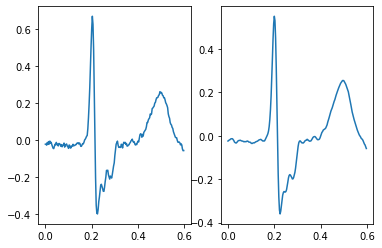

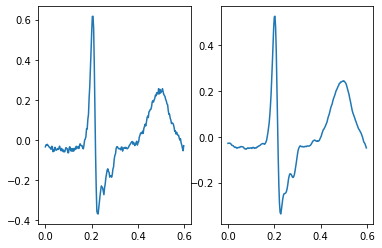

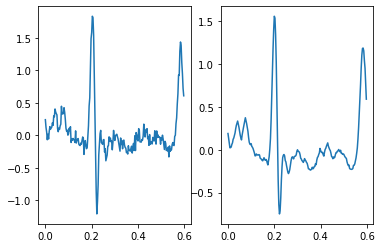

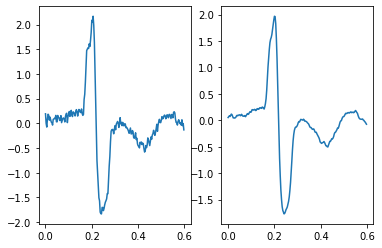

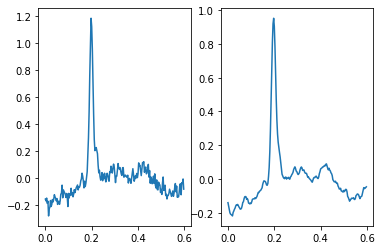

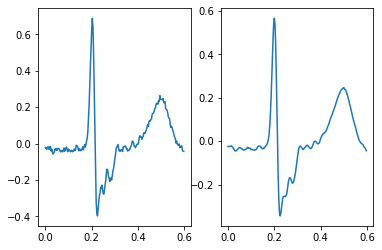

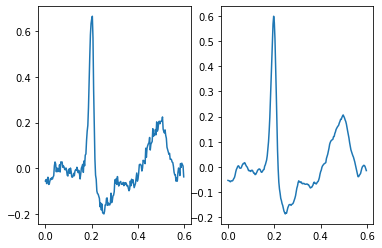

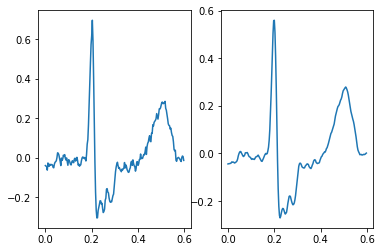

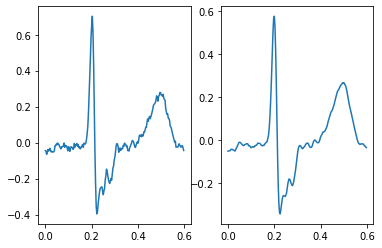

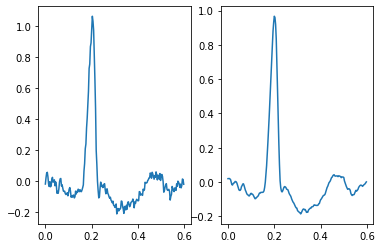

In [ ]:


gen = Gen_dcgan_gp_1d(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

gen.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "gen_S.pt")))

noise = torch.randn((10, Z_DIM, 1)).to(device)

with torch.no_grad():
  gen.eval()

  signal = gen(noise)
  signal = signal.squeeze(1).to('cpu')
 

  plot_heartbeats(signal)
  #print(torch.max(signal))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([15, 216])


tensor(3.0971)

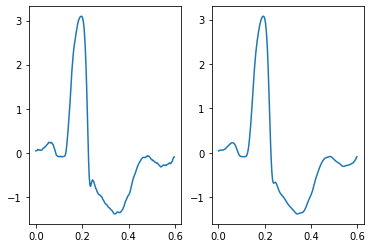

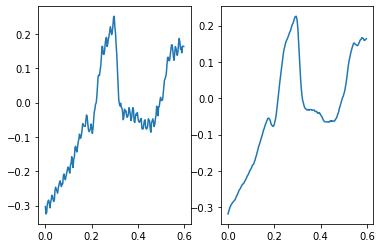

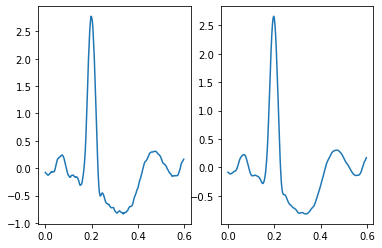

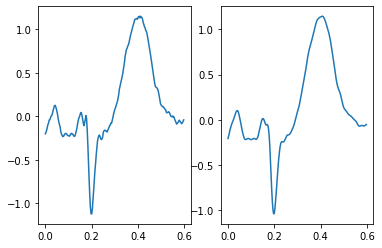

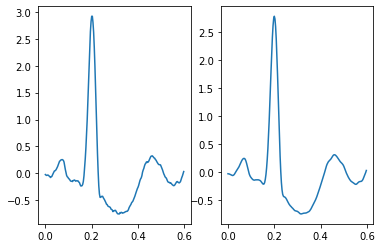

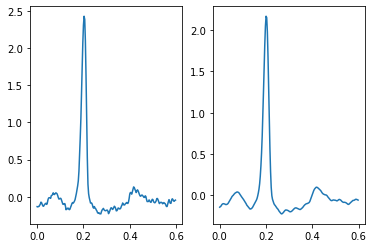

In [ ]:
dataset = ECGDataset(x_test_F,y_test_F)
dataloader = DataLoader(dataset=dataset,
                        batch_size=15,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        )

sample,_ = next(iter(dataloader))
print(sample.shape)

plot_heartbeats(sample.squeeze().to('cpu'))
torch.max(sample.squeeze().to('cpu'))

## Adding generated beats to the dataset

In [ ]:
augmented_dataset = ECGDataset(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Superventricular beats

In [ ]:
#44024
gen = Generator(Z_DIM).to(device)

gen.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "gen_S.pt")))
gen.eval()
with torch.no_grad():
  for i in range(int(630*1.6)):
    noise = torch.randn((64, Z_DIM, 1)).to(device)
    beat = gen(noise)
    beat = beat.squeeze(1).to('cpu')
    beat = savgol_filter(beat,6,2)
    beat = torch.tensor(beat)

    augmented_dataset.addItem(beat,2)




<ipython-input-104-337cf80e50b7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beat = torch.tensor(beat)


## Ventricular beats

In [ ]:
#41212
gen = Generator(Z_DIM).to(device)

gen.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "gen_V.pt")))
gen.eval()
with torch.no_grad():
  for i in range(int(600*1.7)):
    noise = torch.randn((64, Z_DIM, 1)).to(device)
    beat = gen(noise)
    beat = beat.squeeze(1).to('cpu')
    beat = savgol_filter(beat,6,2)
    beat = torch.tensor(beat)
    augmented_dataset.addItem(beat,3)

<ipython-input-105-b6ca693afeb2>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beat = torch.tensor(beat)


## Fusion beats

In [ ]:
#44586
gen = Generator(Z_DIM).to(device)

gen.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "gen_F.pt")))
gen.eval()

with torch.no_grad():
  for i in range(int(650*1.6)):
    noise = torch.randn((64, Z_DIM, 1)).to(device)
    beat = gen(noise)
    beat = beat.squeeze(1).to('cpu')
    #beat = savgol_filter(beat,6,2)
    beat = torch.tensor(beat)
    augmented_dataset.addItem(beat,0)


<ipython-input-106-07259baede25>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beat = torch.tensor(beat)


#Classification model

## CNN Model

In [ ]:
from torch.nn.modules.pooling import MaxPool1d


class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()

    self.conv1 =    nn.Conv1d(1,128,kernel_size=16,padding ='same',dtype = torch.float32)

    self.layers = nn.Sequential(
     
        nn.ReLU(),
        nn.BatchNorm1d(128,dtype = torch.float32),
        nn.Conv1d(128,32,kernel_size = 16,padding = 'same',dtype = torch.float32),
        nn.ReLU(),
        nn.BatchNorm1d(32,dtype = torch.float32),
        nn.Conv1d(32,9,kernel_size = 16,padding = 'same',dtype = torch.float32),
        nn.ReLU(),
        nn.MaxPool1d(2,stride=2),
        nn.Flatten(),
        nn.Linear(972,128,dtype = torch.float32),
        nn.ReLU(),
        nn.Linear(128,32,dtype = torch.float32),
        nn.ReLU(),
        nn.Linear(32,4,dtype = torch.float32),
    )
  def forward(self,x):
    x = self.conv1(x)

    out = self.layers(x)

    return out


## Training

In [ ]:


training_dataset = ECGDataset(x_train,y_train)
BATCH_SIZE = 128

train_loader = DataLoader(dataset=training_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          pin_memory=True,
                          
                          )

cnn = CNN().cuda()
initialize_weights(cnn)
critireon = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr = 0.0002)

NUM_EPOCHS = 6
cnn.train()
for epoch in range(NUM_EPOCHS):
  for batch_idx,h_l in enumerate(train_loader):

    heartbeats = h_l[0].to(device)
    heartbeats = torch.unsqueeze(heartbeats,dim = 1)
    labels = h_l[1]
    labels = labels.long()
    labels = labels.to(device)
    predictions = cnn(heartbeats)

    loss = critireon(predictions,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(batch_idx %100 == 0):
     print(
                    f"Epoch [{epoch:3d} / {NUM_EPOCHS:3d}]      Batch {batch_idx:4d}/{len(train_loader):5d} \
                         Loss : {loss.item(): 6.4f}"
                )
  
   

torch.save(cnn.state_dict(),os.path.join(MODEL_SAVE_PATH, "cnn_model_less.pt"))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [  0 /   6]      Batch    0/  629                          Loss :  1.3540
Epoch [  0 /   6]      Batch  100/  629                          Loss :  0.3023
Epoch [  0 /   6]      Batch  200/  629                          Loss :  0.1897
Epoch [  0 /   6]      Batch  300/  629                          Loss :  0.1030
Epoch [  0 /   6]      Batch  400/  629                          Loss :  0.0733
Epoch [  0 /   6]      Batch  500/  629                          Loss :  0.1366
Epoch [  0 /   6]      Batch  600/  629                          Loss :  0.0857
Epoch [  1 /   6]      Batch    0/  629                          Loss :  0.0521
Epoch [  1 /   6]      Batch  100/  629                          Loss :  0.1293
Epoch [  1 /   6]      Batch  200/  629                          Loss :  0.0758
Epoch [  1 /   6]      Batch  300/  629                          Loss :  0.0673
Epoch [  1 /   6]      Batch  400/  629                          Loss :  0.0407
Epoch [  1 /   6]      Batch  500/  629 

## training with new dataset

In [ ]:
BATCH_SIZE = 516

train_loader = DataLoader(dataset=dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          pin_memory=True,
                          
                          )

cnn = CNN().cuda()

critireon = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr = 0.0002)

NUM_EPOCHS = 10
cnn.train()

for epoch in range(NUM_EPOCHS):

  for batch_idx,h_l in enumerate(train_loader):

    heartbeats = h_l[0].to(device)

    heartbeats = torch.unsqueeze(heartbeats,dim = 1)
    labels = h_l[1]
    labels = labels.long()
    labels = labels.to(device)

    predictions = cnn(heartbeats)


    loss = critireon(predictions,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(batch_idx %100 == 0):
     print(
                    f"Epoch [{epoch:3d} / {NUM_EPOCHS:3d}]      Batch {batch_idx:4d}/{len(train_loader):5d} \
                         Loss : {loss.item(): 6.5f}"
                )
   

torch.save(cnn.state_dict(),os.path.join(MODEL_SAVE_PATH, "cnn_model_augmented_less_1.pt"))


Epoch [  0 /  10]      Batch    0/  536                          Loss :  1.38598
Epoch [  0 /  10]      Batch  100/  536                          Loss :  0.07223
Epoch [  0 /  10]      Batch  200/  536                          Loss :  0.02942
Epoch [  0 /  10]      Batch  300/  536                          Loss :  0.05120
Epoch [  0 /  10]      Batch  400/  536                          Loss :  0.02693
Epoch [  0 /  10]      Batch  500/  536                          Loss :  0.04757
Epoch [  1 /  10]      Batch    0/  536                          Loss :  0.04859
Epoch [  1 /  10]      Batch  100/  536                          Loss :  0.01580
Epoch [  1 /  10]      Batch  200/  536                          Loss :  0.01793
Epoch [  1 /  10]      Batch  300/  536                          Loss :  0.01396
Epoch [  1 /  10]      Batch  400/  536                          Loss :  0.02531
Epoch [  1 /  10]      Batch  500/  536                          Loss :  0.01844
Epoch [  2 /  10]      Batch

## Testing

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score

test_dataset = ECGDataset(x_test,y_test)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          pin_memory=True)
                          

cnn = CNN().cuda()

cnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "cnn_model_less_ok.pt")))
y_true = []
y_pred = []
with torch.no_grad(): 
    for data in test_loader: 
        inputs, outputs = data 
        
        y_true.append(outputs.item())
        
        inputs = torch.unsqueeze(inputs,dim = 1)
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        predicted_outputs = cnn(inputs) 
        _, predicted = torch.max(predicted_outputs, 1) 
        y_pred.append(float(predicted.item()))

print(classification_report(y_true,y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       161
         1.0       0.98      0.99      0.99     17970
         2.0       0.92      0.60      0.72       606
         3.0       0.92      0.95      0.93      1402

    accuracy                           0.98     20139
   macro avg       0.92      0.83      0.86     20139
weighted avg       0.98      0.98      0.98     20139



In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score

test_dataset = ECGDataset(x_test,y_test)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          pin_memory=True)
                          

cnn = CNN().cuda()

cnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "cnn_model_augmented_less_ok.pt")))
y_true = []
y_pred = []
with torch.no_grad(): 
    for data in test_loader: 
        inputs, outputs = data 
        
        y_true.append(outputs.item())
        
        inputs = torch.unsqueeze(inputs,dim = 1)
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        predicted_outputs = cnn(inputs) 
        _, predicted = torch.max(predicted_outputs, 1) 
        y_pred.append(float(predicted.item()))

print(classification_report(y_true,y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83       161
         1.0       0.99      0.98      0.99     17970
         2.0       0.79      0.78      0.79       606
         3.0       0.85      0.97      0.91      1402

    accuracy                           0.97     20139
   macro avg       0.87      0.89      0.88     20139
weighted avg       0.97      0.97      0.97     20139

